In [1]:
%matplotlib inline

import os, pathlib
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output
from tqdm import tqdm
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
import pickle

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        mouse_defs = params.mouse_defs
        monkey_defs = params.monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
    finally:
        os.chdir(nbPath)
    
    # %run "S1-mouse-M1-decoding.ipynb"
    
    print('Done!')

FIGPATH = params.figPath / 'figS6-mouse-additional'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done!


### Fig S8A: CCA for mouse for four conditions


In [2]:
defs = mouse_defs

animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal, 'mat'))

AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_pull_mouse(df)
    AllDFs.append(df)

clear_output()

In [3]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)
warnings.filterwarnings("default")


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))

print(f'{len(pairFileList2)=}')


len(pairFileList1)=13
len(pairFileList2)=13


In [4]:
def plot_mouse_cca(ax, allDFs_M1):
    defs = params.mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch_pull, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.exec_epoch_pull, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData1 = dt.get_data_array(allDFs_M1, defs.exec_epoch_pull, area=defs.areas[0], model=defs.n_components)

    n_iter = params.n_iter * 10
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for sessionData in AllData1:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, df2 in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    len_trial = int(np.round(np.diff(defs.WINDOW_exec_pull)/defs.BIN_SIZE))

    AllData1 = dt.get_data_array(side1df, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $4$ mice',
            ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])



/tmp/ipykernel_23620/2839497853.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  len_trial = int(np.round(np.diff(defs.WINDOW_exec_pull)/defs.BIN_SIZE))
/home/jcc319/anaconda3/envs/cca2/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


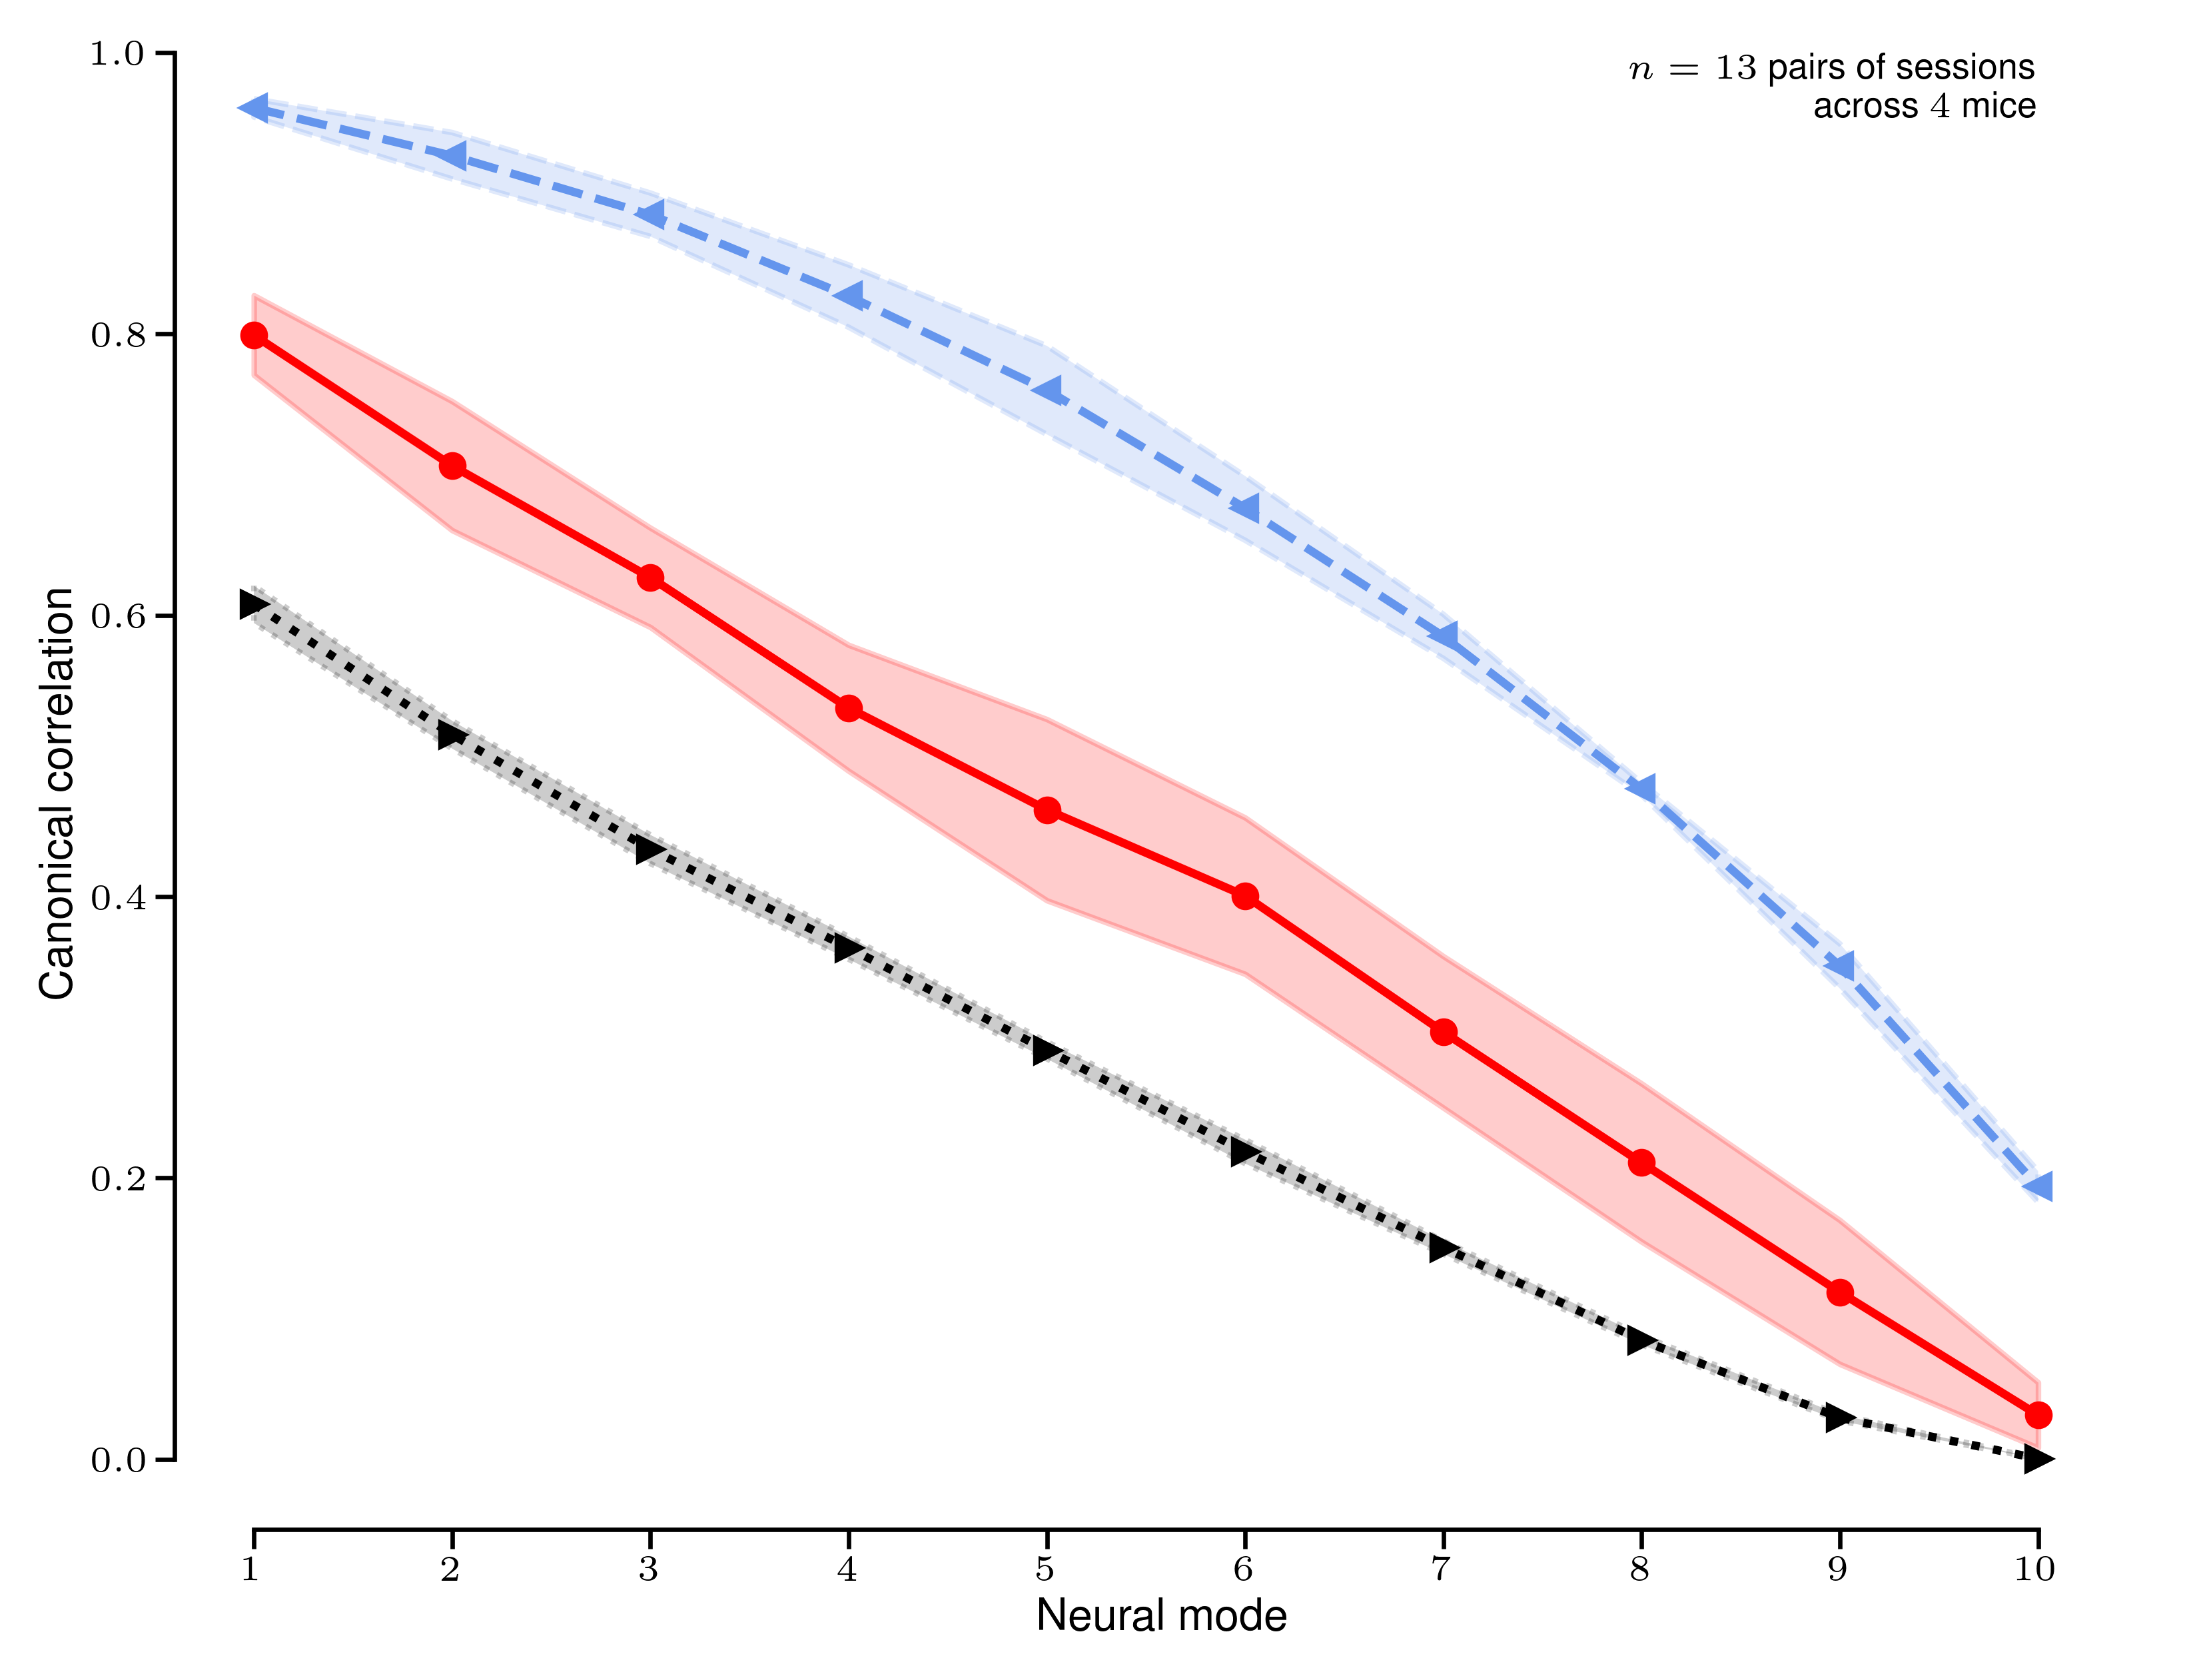

In [5]:
fig = plt.figure()
plot_mouse_cca(plt.gca(), allDFs_M1)
fig.savefig(FIGPATH / 'mouse-cca-pull-4targets.pdf', format='pdf', bbox_inches='tight')


### Fig S8B: Decoding for mouse MCx

In [6]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [7]:
@utility.report
def plot_m1_decoding_behav_corr(ax, AllDFs, across_corrs_mouse,colormap = 'viridis'):
    defs = mouse_defs
    
    #=========================
    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(AllDFs)):
        animal1 = df1.mouse[0]

        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode, area=defs.areas[0],
                                                    n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        *_,n_time,n_comp = AllData.shape
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        # resizing
        X1 = AllData1.reshape((-1, n_time, n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))

        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model.fit(x_train=x_train, y_train=y_train, epochs = 10)
            lstm_model.predict(x_test, y_test)
            fold_score.append(lstm_model.score)
        fold_score = np.median(fold_score)
        within_score[df1.file[0]] = fold_score


        aligned_score[df1.file[0]] = {}
        unaligned_score[df1.file[0]] = {}
        for j, df2 in enumerate(AllDFs):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            
            #================================
            # Across sesisons
            AllData, AllVel = defs.get_data_array_and_vel([df1, df2], defs.exec_epoch_decode,
                                                          area=defs.areas[0], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = AllData1.shape
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,3))
            AllVel2 = AllVel2.reshape((-1,n_time,3))
            
            #================================
            # Aligned
            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

            #================================
            # Unaligned
            lstm_model1 = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model1.fit(x_train=X1, y_train=AllVel1)
            lstm_model1.predict(X2, AllVel2)
            lstm_model2 = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model2.fit(x_train=X2, y_train=AllVel2)
            lstm_model2.predict(X1, AllVel1)

            unaligned_score[df1.file[0]][df2.file[0]] = (lstm_model1.score.mean() + lstm_model2.score.mean()) / 2


    # return within_score, aligned_score, unaligned_score
    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    unal_vals = []
    al_vals = []
    wi_vals = []

    pop_behav_corr = []
    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            behav = np.array(across_corrs_mouse[file1][file2])
            behav = np.mean(behav[behav>params.Behav_corr_TH])
            pop_behav_corr.append(behav)

    min = np.min(pop_behav_corr)
    max = np.max(pop_behav_corr)
    norm = mpl.colors.Normalize(vmin=min, vmax=max+(max-min)*0.1)
    # print(np.min(pop_behav_corr), np.max(pop_behav_corr))

    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            behav = np.array(across_corrs_mouse[file1][file2])
            behav = np.mean(behav[behav>params.Behav_corr_TH])
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color = mpl.colormaps[colormap](norm(behav)), lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.7)
            ax.plot([1,2], [al_val, wi_val2],
                    color = mpl.colormaps[colormap](norm(behav)), lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.7)
            #for stats
            unal_vals.append(unal_val)
            al_vals.append(al_val)
            wi_vals.append(wi_val1)
            wi_vals.append(wi_val2)
    plt.colorbar(cm.ScalarMappable(norm = norm, cmap = colormap), ax = ax)

    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,.85])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,2])
    ax.spines['left'].set_bounds([0,.8])

    #stats ###########################################################################
    #calc stats
    ##for paired stats
    compare_upper_stats = stats.wilcoxon(np.repeat(al_vals,2), wi_vals)
    compare_lower_stats = stats.wilcoxon(al_vals, unal_vals)

    print("Across vs within:", compare_upper_stats)
    print("Across vs control:", compare_lower_stats)

    #annotate stats
    if params.annotate_stats:
        ymin, ymax = ax.get_ylim()
        liney = ymax*0.95
        texty = ymax*1
        line_kwargs = dict(linewidth = 0.5, color = 'k')
        text_kwargs = dict(ha='center', va='center')

        ax.plot([0,1], [liney, liney], **line_kwargs)
        ax.plot([1,2], [liney, liney], linestyle = '--', **line_kwargs)
        
        ax.text(0.5, texty, dt.get_signif_annot(compare_upper_stats[1]), **text_kwargs)
        ax.text(1.5, texty, dt.get_signif_annot(compare_lower_stats[1]), **text_kwargs)


    return within_score, aligned_score, unaligned_score

In [ ]:
allDFs_M1, _ = get_full_mouse_data()

try:
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(nbPath)
    
across_corrs_mouse = trim_across_mouse_corr(allDFs_M1)

plt.close('all')
set_rc()
fig=plt.figure(dpi=100)
ax = fig.add_subplot()
cmap = 'cool'
within_score, aligned_score, unaligned_score = plot_m1_decoding_behav_corr(ax, allDFs_M1, across_corrs_mouse, colormap=cmap)
plt.savefig(FIGPATH / ('mouse_m1_decoding_behav_corr.pdf'), format = 'pdf')
plt.show()

clear_output()

### Fig S8C&D: CCA for mouse MCx vs Str

#### Get data

In [9]:
defs = mouse_defs
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [10]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)
warnings.filterwarnings("default")


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))

print(f'{len(pairFileList2)=}')


len(pairFileList1)=13
len(pairFileList2)=13


In [11]:
side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

side1df = [allDFs_Str[i] for i,_ in pairFileList2]
side2df = [allDFs_Str[j] for _,j in pairFileList2]
AllData1_ = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
AllData2_ = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')
warnings.filterwarnings("default")

min_trials=22
min_time=15
min_trials_=22
min_time_=15


#### Fig S8C: CCA across modes

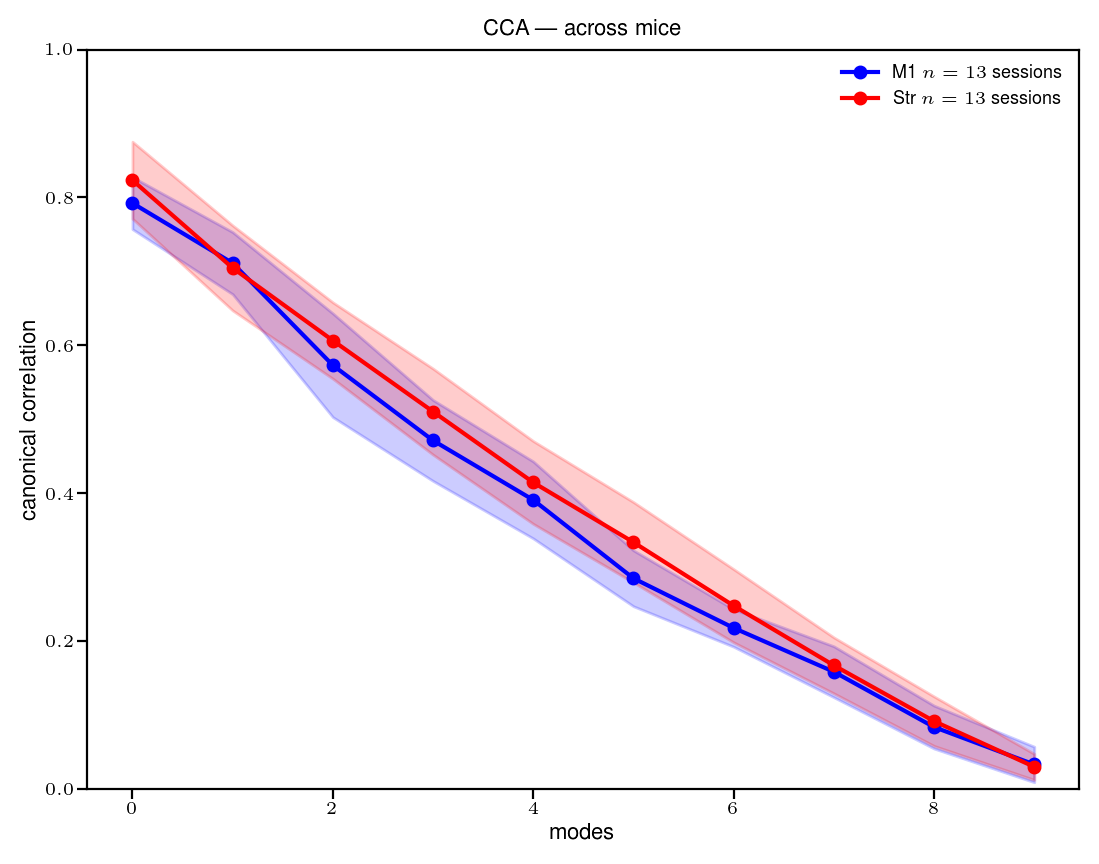

In [12]:
defs = mouse_defs
allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
    allCCs1.append(dt.canoncorr(data1, data2))
allCCs1 = np.array(allCCs1).T

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[0]} $n={allCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{defs.areas[1]} $n={allCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('modes')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across mice', usetex=True);

plt.savefig(FIGPATH / 'mouse-str-m1-cca-modes.pdf', format='pdf', bbox_inches='tight')


#### Fig S8D: Mean of top 4 CCs

In [13]:
defs = mouse_defs
allCCs_m1 = []
allCCs_str = []

for sessionData1_m,sessionData2_m, sessionData1_s,sessionData2_s in zip(AllData1,AllData2, AllData1_, AllData2_):
    data1 = np.reshape(sessionData1_m[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2_m[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs_m1.append(dt.canoncorr(data1, data2)[:4].mean())

    data1 = np.reshape(sessionData1_s[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2_s[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
    allCCs_str.append(dt.canoncorr(data1, data2)[:4].mean())


allCCs_str = np.array(allCCs_str).T
allCCs_m1 = np.array(allCCs_m1).T


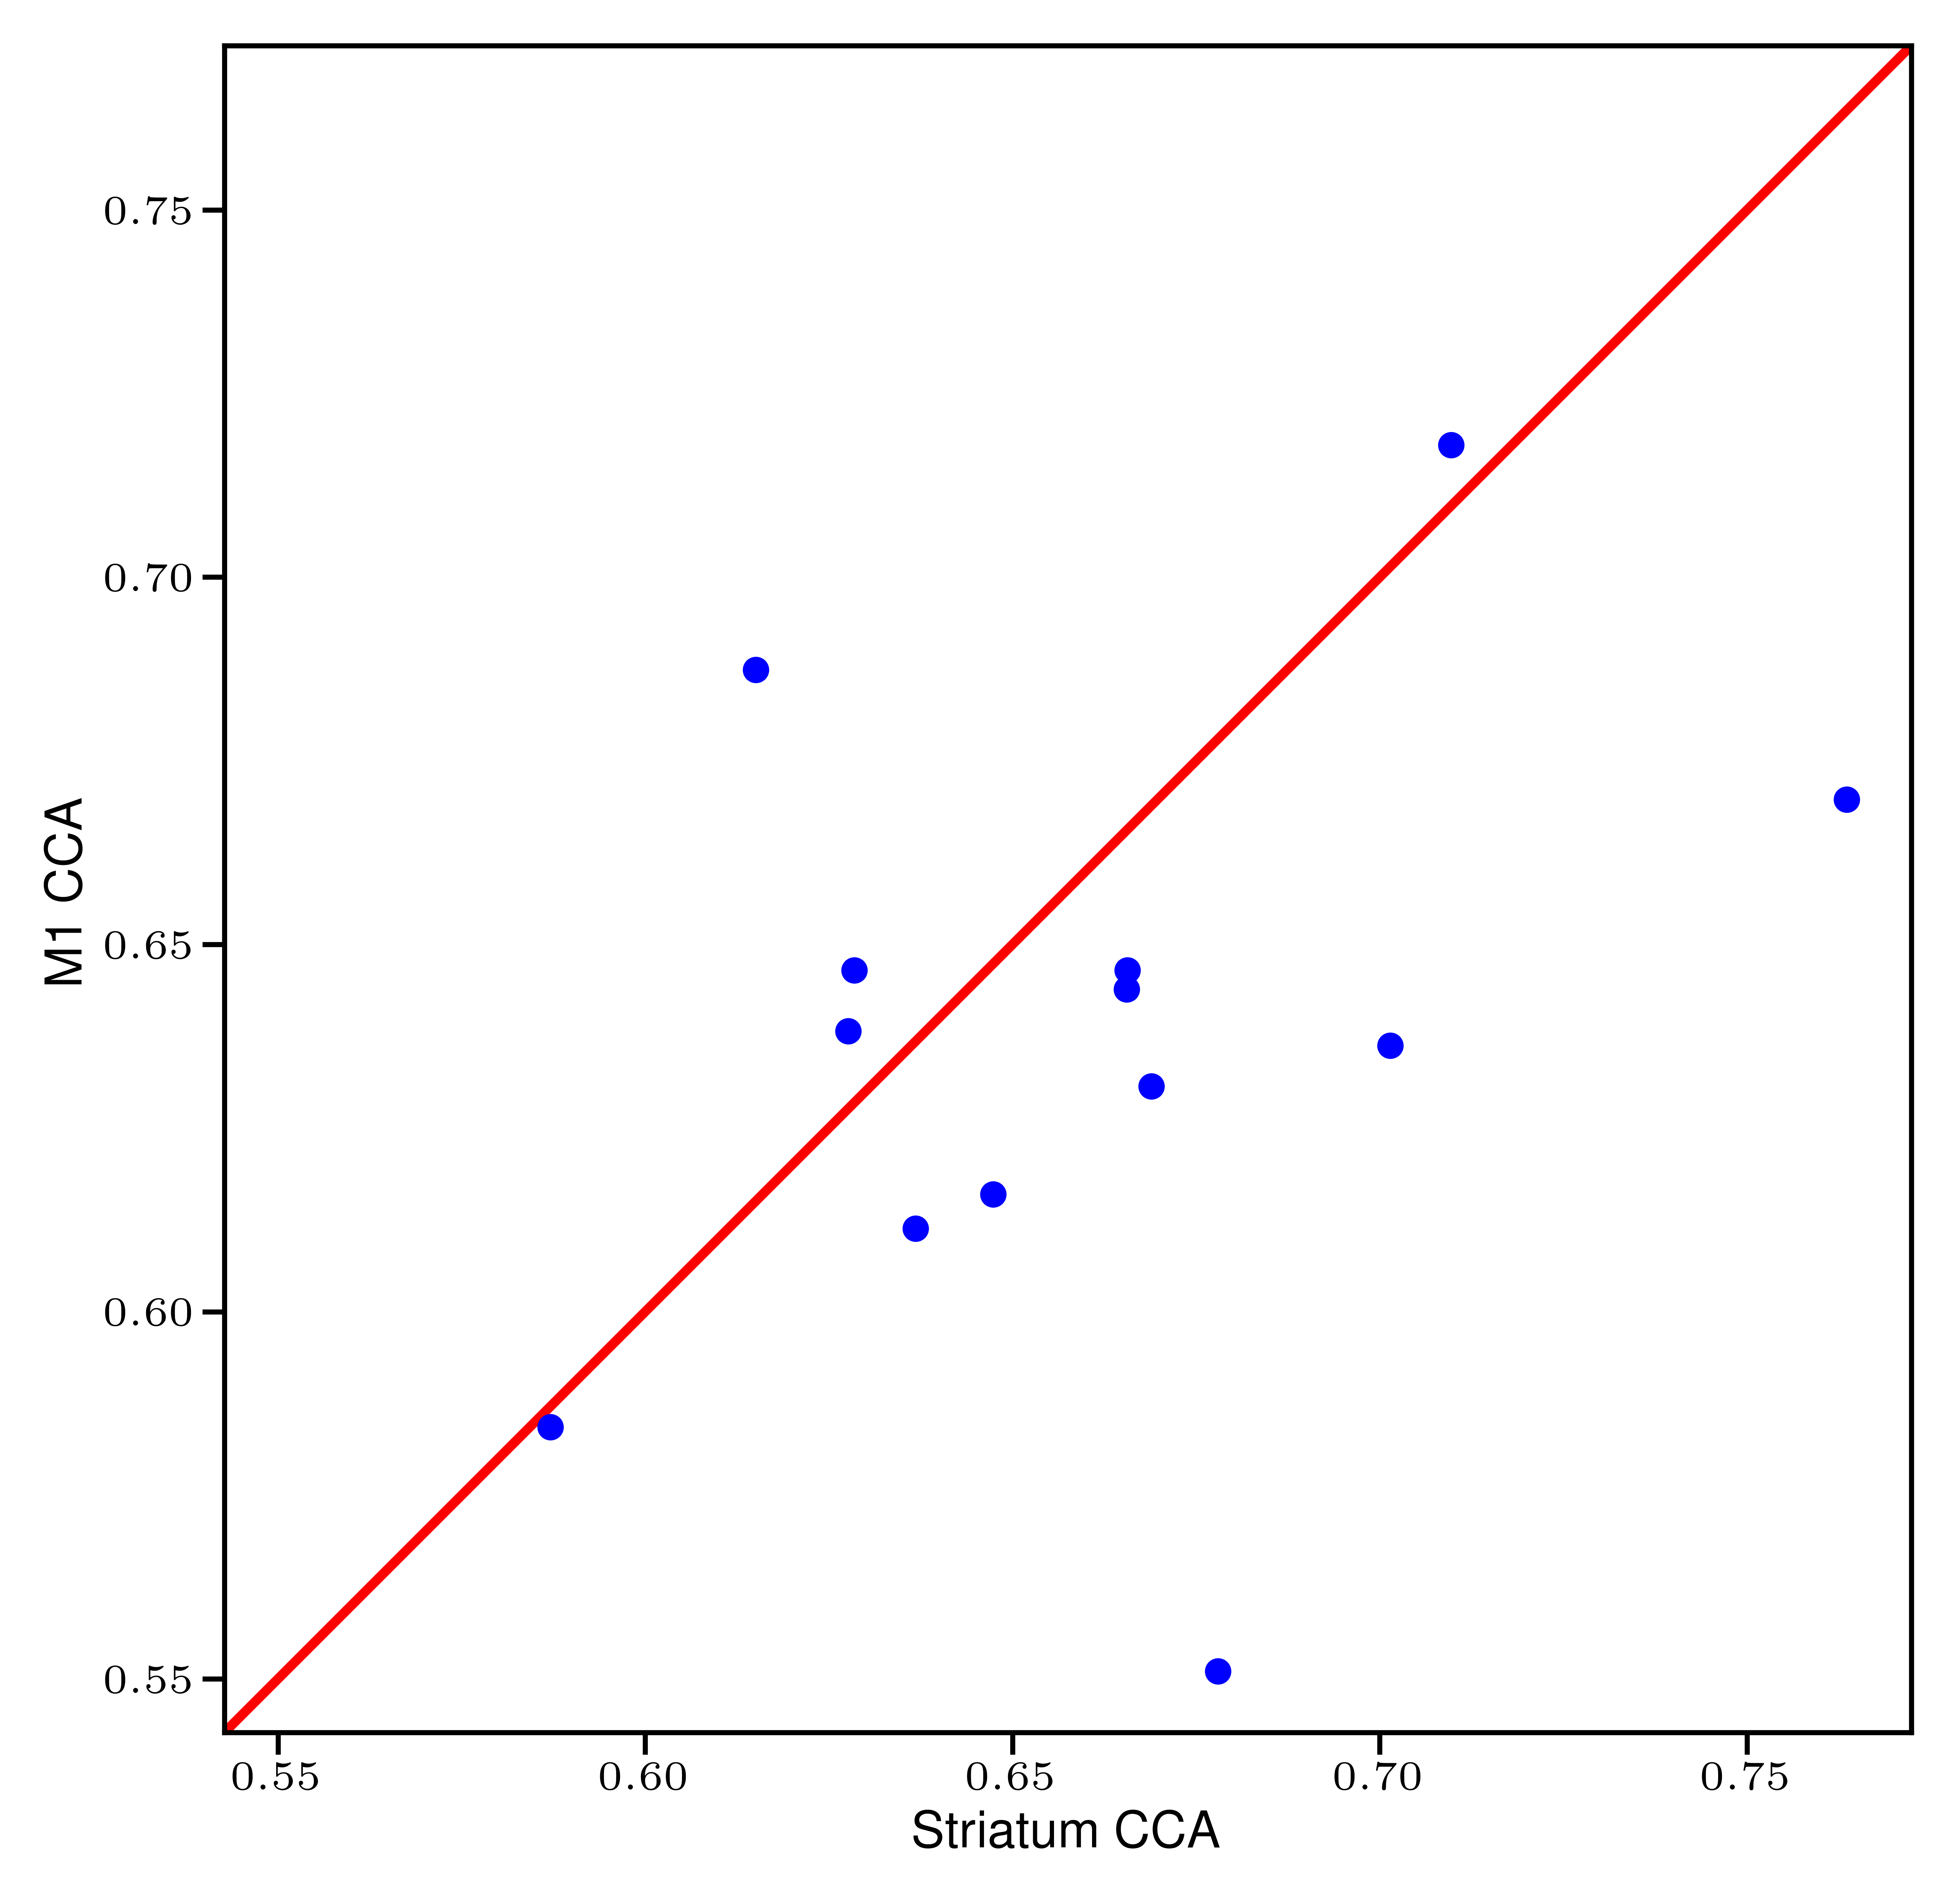

In [14]:
fig, ax = plt.subplots()

ax.scatter(allCCs_str, allCCs_m1, marker = 'o', color = 'b', s = 10)
ax.axline([0, 0], [1, 1], color='r', transform = ax.transAxes, zorder=-1)

ax.set_aspect(1)
xmin, xmax, ymin, ymax = ax.axis()
ax.axis([min(xmin,ymin), max(xmax,ymax), min(xmin,ymin), max(xmax,ymax)])
ax.set_xlabel('Striatum CCA')
ax.set_ylabel('M1 CCA')

fig.savefig(FIGPATH / 'mouse-str-m1-cca-mean.pdf', format='pdf', bbox_inches='tight')

### Fig S8E: Decoding for mouse MCx vs Str

In [15]:
def get_full_mouse_data():
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str


def plot_mouse_aligned_decoding(AllDFs, area_code=1):
    defs = mouse_defs
    aligned_score = {}
    for i, df1 in enumerate(tqdm(AllDFs)):
        animal1 = df1.mouse[0]

        aligned_score[df1.file[0]] = {}
        for j, df2 in enumerate(AllDFs):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            
            AllData, AllVel = defs.get_data_array_and_vel([df1, df2], defs.exec_epoch_decode,
                                                          area=defs.areas[area_code], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = AllData1.shape
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,3))
            AllVel2 = AllVel2.reshape((-1,n_time,3))

            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

    return aligned_score

In [ ]:
allDFs_M1, allDFs_Str = get_full_mouse_data()
str_align = plot_mouse_aligned_decoding(allDFs_Str, area_code=1)
m1_align = plot_mouse_aligned_decoding(allDFs_M1, area_code=0)
clear_output()

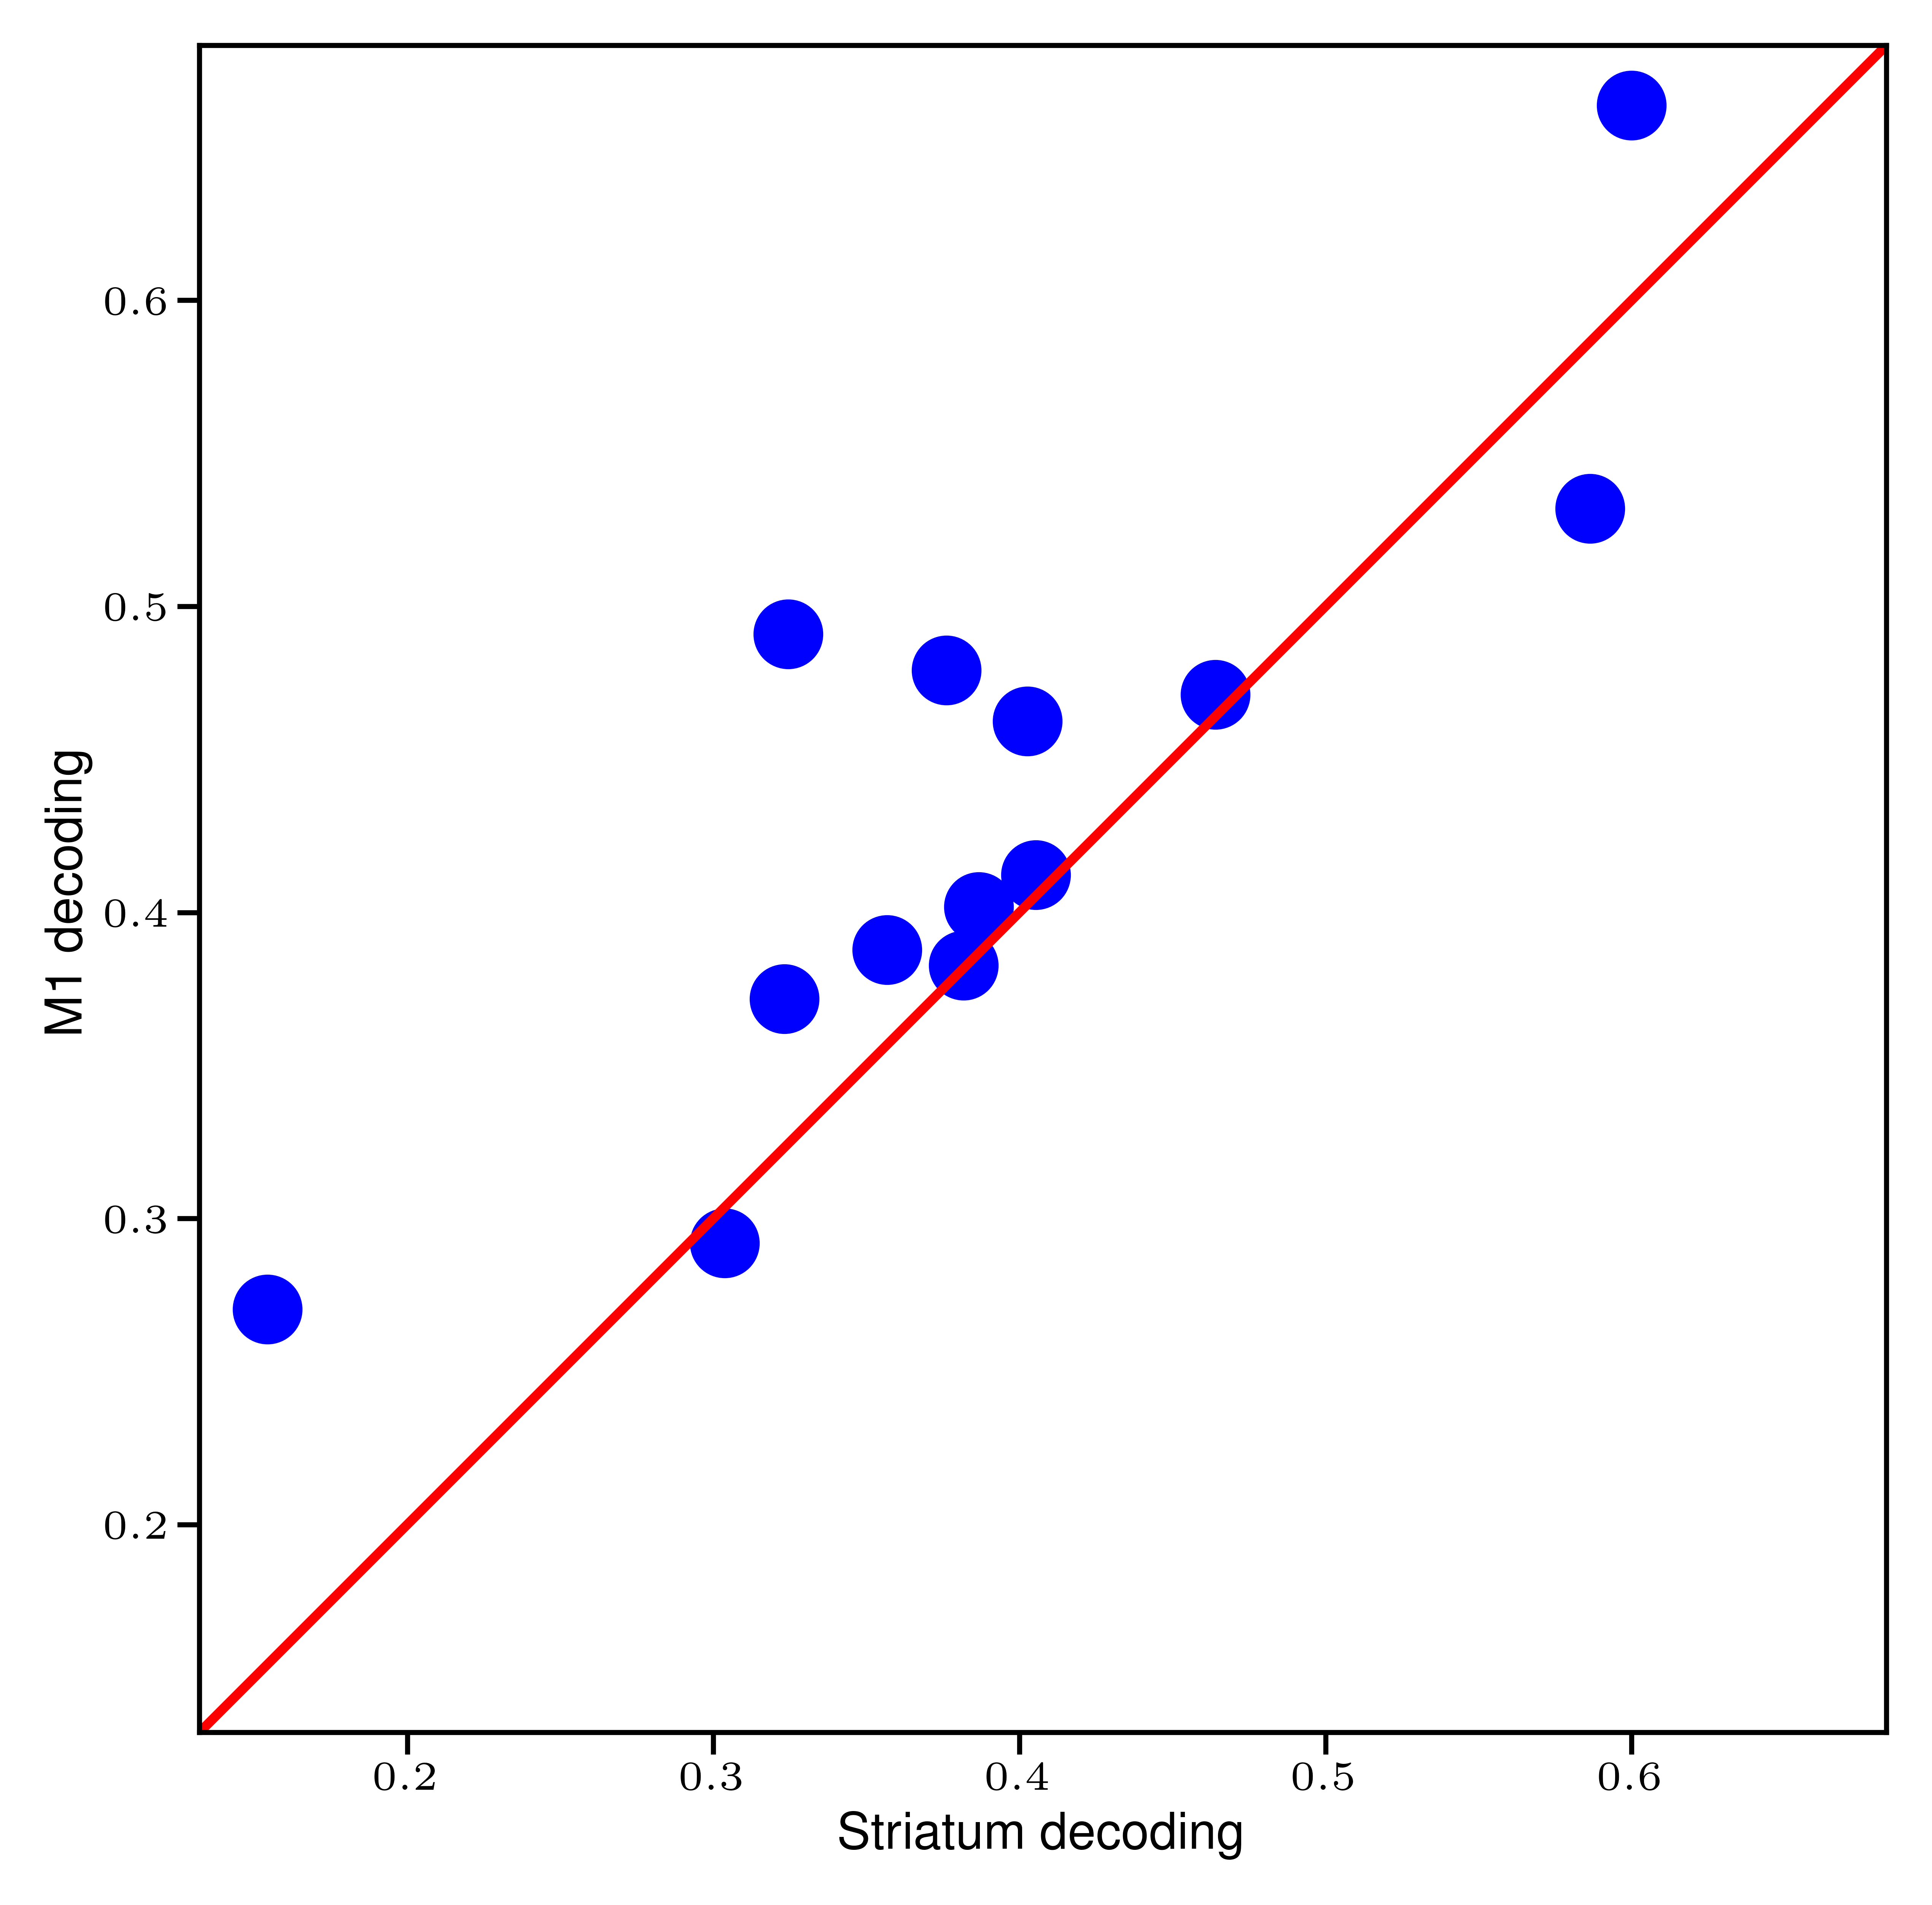

In [17]:
set_rc()
fig, ax = plt.subplots()

for key1,val in m1_align.items():
    for key2 in val:
        ax.plot(str_align[key1][key2], m1_align[key1][key2], 
                marker = 'o', color = 'b', ms = 10)
ax.axline([0, 0], [1, 1], color='r', transform = ax.transAxes)

ax.set_aspect(1)
xmin, xmax, ymin, ymax = ax.axis()
ax.set_xlim([min(xmin, ymin), max(xmax, ymax)])
ax.set_ylim([min(xmin, ymin), max(xmax, ymax)])
ax.set_xlabel('Striatum decoding')
ax.set_ylabel('M1 decoding')

fig.savefig(FIGPATH / 'mouse-str-m1-decoding.pdf', format='pdf', bbox_inches='tight')

### FigS6F: Behavioral correlation vs decoding

In [18]:
try:
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"

finally:
    os.chdir(nbPath)

@utility.report
def get_full_monkey_data():
    defs = monkey_defs
    full_list_MCx = []
    for animal, sessionList in GoodDataList_CO[defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [19]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [20]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "_monkey-corr.ipynb"
finally:
    os.chdir(nbPath)

try:
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-corr.ipynb"
finally:
    os.chdir(nbPath)
        
@utility.report
def plot_monkey_decode_corr(ax, full_list, allDFs_MCx):
    defs = monkey_defs
        
    across_corrs_monkeys = trim_across_monkey_corr(allDFs_MCx)

    pairIndex_across = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairIndex_across.append((I,J))
            
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        pathPickle = root / 'monkey-pickles' / f'{allDFs_MCx[id1].session[0]}-{allDFs_MCx[testId].session[0]}_aligned.p'

        assert os.path.exists(pathPickle), 'Run figure 2 first to save the decoding data!'

        with open(pathPickle,"rb") as f:
            reg_scores_across.append(pickle.load(f))
    pop_score_across = np.array(reg_scores_across)
            
            
    corr_monkey=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = allDFs_MCx[id1] , allDFs_MCx[testId]
        behav = np.array(across_corrs_monkeys[df1.session[0]][df2.session[0]])
        behav = behav[behav>params.Behav_corr_TH]
        decode = pop_score_across[i]
        corr_monkey.append((decode , np.mean(behav)))
    corr_monkey = np.array(corr_monkey)   


    #plotting
    ax.scatter(corr_monkey[:,1],corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([.15,1])
    ax.spines['left'].set_bounds([.2,1])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    
@utility.report
def plot_mouse_decode_corr(ax, AllDFs):
    defs = mouse_defs
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

    M1_scores = []
    for (id1, testId) in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch_decode,
                                                      area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        
        # resizing
        _,n_trial,n_time,n_comp = AllData1.shape
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))
        AllVel2 = AllVel2.reshape((-1,n_time,3))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_time,n_comp))
        V = V.reshape((-1,n_time,n_comp))

        lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        lstm_model.fit(x_train=U, y_train=AllVel1)
        lstm_model.predict(V, AllVel2)
        M1_scores.append(lstm_model.score.mean())

    M1_score_across = np.array(M1_scores)


    Str_scores = []
    for (id1, testId) in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch_decode,
                                                      area=defs.areas[1], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        
        # resizing
        _,n_trial,n_time,n_comp = AllData1.shape
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))
        AllVel2 = AllVel2.reshape((-1,n_time,3))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_time,n_comp))
        V = V.reshape((-1,n_time,n_comp))

        lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
        lstm_model.fit(x_train=U, y_train=AllVel1)
        lstm_model.predict(V, AllVel2)
        Str_scores.append(lstm_model.score.mean())

    Str_score_across = np.array(Str_scores)


    corr_mice=[]
    for i, (id1, testId) in enumerate(pairIndex_across):
        df1, df2 = AllDFs[id1] , AllDFs[testId]
        behav = np.array(across_corrs_mice[df1.file[0]][df2.file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        M1_decode = M1_score_across[i]
        Str_decode = Str_score_across[i]
        corr_mice.append((M1_decode , np.mean(behav), Str_decode))
    corr_mice = np.array(corr_mice)

    #plotting
    ax.scatter(corr_mice[:,1],corr_mice[:,0],color=params.colors.MouseM1, label='Mice M1', zorder=1)
    ax.scatter(corr_mice[:,1],corr_mice[:,2],color=params.colors.MouseStr, label='Mice Str', zorder=1)

In [ ]:
fig=plt.figure(dpi=100)
ax = fig.add_subplot()

full_list, allDFs_MCx = get_full_monkey_data()
allDFs_M1, _ = get_full_mouse_data()

plot_mouse_decode_corr(ax, allDFs_M1)
plot_monkey_decode_corr(ax, full_list, allDFs_MCx)

fig.savefig(FIGPATH / 'decode-behav-corr.pdf', format='pdf', bbox_inches='tight')
clear_output()